In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)

Mounted at /content/mnt


**Assignment 2**

**Theme Group: Engineering Image Analysis**

**Author: Jaydeep Rade, Dhruv Gamdha**

**TASK 1**

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
filepath = '/content/mnt/MyDrive/Colab Notebooks/ME592X/Assignment2/leaves'
files = os.listdir('/content/mnt/MyDrive/Colab Notebooks/ME592X/Assignment2/leaves')
Images = {}
for file in files:
  Images[file] = cv2.imread('/content/mnt/MyDrive/Colab Notebooks/ME592X/Assignment2/leaves/%s'%file)
  cv2_imshow(Images[file])

Output hidden; open in https://colab.research.google.com to view.

In [3]:
def rotate(img):
  width = img.shape[1]
  height = img.shape[0]
  angles = [i for i in range(10, 360, 10)]
  angle = np.random.choice(angles)
  M = cv2.getRotationMatrix2D((width/2,height/2),angle,1)
  rotated_img = cv2.warpAffine(img,M,(width,height))
  return rotated_img

def shift(img):
  width = img.shape[1]
  height = img.shape[0]
  shifts = [i for i in range(-200, 200, 10)]
  shifts.remove(0)
  Tx = np.random.choice(shifts)
  Ty = np.random.choice(shifts)
  M = np.float32([[1,0,Tx],[0,1,Ty]])
  shifted_img = cv2.warpAffine(img,M,(width,height))
  return shifted_img

def scale(img):
  scales = np.arange(10, 210, 10)
  scale_w = np.random.choice(scales)
  scale_h = np.random.choice(scales)
  new_width = int(img.shape[1] * scale_w / 100) 
  new_height = int(img.shape[0] * scale_h / 100)
  dim = (new_width, new_height)
  resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return resized_img

def warp(img):
    width = img.shape[1]
    height = img.shape[0]
    pts1 = np.float32([ [np.random.choice(height), np.random.choice(width)],
             [np.random.choice(height), np.random.choice(width)],
             [np.random.choice(height), np.random.choice(width)]])
    
    pts2 = np.float32([ [np.random.choice(height), np.random.choice(width)],
             [np.random.choice(height), np.random.choice(width)],
             [np.random.choice(height), np.random.choice(width)]])
    
    M = cv2.getAffineTransform(pts1,pts2)
    warped_img = cv2.warpAffine(img,M,(width,height))  
    return warped_img

def nothing(img):
  return img

def patch_gen(img, size=150):
  if size>img.shape[0] or size>img.shape[1]:
    return img
  start_w = np.random.choice(abs(img.shape[1]-size))
  start_h = np.random.choice(abs(img.shape[0]-size))
  patch = img[start_h:start_h+size, start_w:start_w+size]
  return patch

augment_dict = {1:rotate, 2:shift, 3:scale, 4:warp, 5:nothing}

 Patch of an Image with Size = 150 


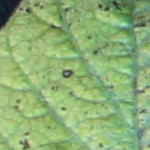

 Rotated Patch 


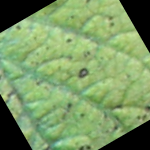

 Shifted Patch 


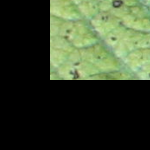

 Scaled Patch 


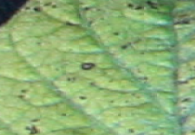

 Warped Patch 


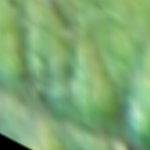

In [24]:
import numpy as np

Patches = {}
for file in files:
  Patches[file] = patch_gen(Images[file], size=150)

# Generating the augmented images using different functions written above
augmented_Images = {}
for i in range(100):
  img = Patches[np.random.choice(files)] #Images[np.random.choice(files)]
  action = np.random.randint(1, 6)
  augmented_Images[i] = augment_dict[action](img)
image = Images[files[0]]

patch = patch_gen(image, size=150)
rotated_patch = rotate(patch)
shifted_patch = shift(patch)
scaled_patch = scale(patch)
warped_patch = warp(patch)

print(' Patch of an Image with Size = 150 ')
cv2_imshow(patch)
print(' Rotated Patch ')
cv2_imshow(rotated_patch)
print(' Shifted Patch ')
cv2_imshow(shifted_patch)
print(' Scaled Patch ')
cv2_imshow(scaled_patch)
print(' Warped Patch ')
cv2_imshow(warped_patch)





**We are using the code from following git repository for ZCA whitening :**  
https://github.com/mwv/zca

In [5]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# ------------------------------------
# file: zca.py
# date: Thu May 21 15:47 2015
# author:
# Maarten Versteegh
# github.com/mwv
# maartenversteegh AT gmail DOT com
#
# Licensed under GPLv3
# ------------------------------------
"""zca: ZCA whitening with a sklearn-like interface
"""

from __future__ import division

import numpy as np
from scipy import linalg

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, as_float_array

class ZCA(BaseEstimator, TransformerMixin):
    def __init__(self, regularization=1e-6, copy=False):
        self.regularization = regularization
        self.copy = copy

    def fit(self, X, y=None):
        """Compute the mean, whitening and dewhitening matrices.
        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data used to compute the mean, whitening and dewhitening
            matrices.
        """
        X = check_array(X, accept_sparse=None, copy=self.copy,
                        ensure_2d=True)
        X = as_float_array(X, copy=self.copy)
        self.mean_ = X.mean(axis=0)
        X_ = X - self.mean_
        cov = np.dot(X_.T, X_) / (X_.shape[0]-1)
        U, S, _ = linalg.svd(cov)
        s = np.sqrt(S.clip(self.regularization))
        s_inv = np.diag(1./s)
        s = np.diag(s)
        self.whiten_ = np.dot(np.dot(U, s_inv), U.T)
        self.dewhiten_ = np.dot(np.dot(U, s), U.T)
        return self

    def transform(self, X, y=None, copy=None):
        """Perform ZCA whitening
        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data to whiten along the features axis.
        """
        check_is_fitted(self, 'mean_')
        X = as_float_array(X, copy=self.copy)
        return np.dot(X - self.mean_, self.whiten_.T)

    def inverse_transform(self, X, copy=None):
        """Undo the ZCA transform and rotate back to the original
        representation
        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data to rotate back.
        """
        check_is_fitted(self, 'mean_')
        X = as_float_array(X, copy=self.copy)
        return np.dot(X, self.dewhiten_) + self.mean_

In [6]:
def ZCA_prewhitening(img, show=False):
   
  # OpenCV functiopn cv2.imread() read the image in BGR format
  X0 = img[:,:,0] # B-Channel
  X1 = img[:,:,1] # G-Channel
  X2 = img[:,:,2] # R-Channel

  trf0 = ZCA().fit(X0)
  X0_whitened = trf0.transform(X0)
  X0_whitened_norm = np.zeros_like(X0_whitened)
  cv2.normalize(X0_whitened,  X0_whitened_norm, 0, 255, cv2.NORM_MINMAX)

  trf1 = ZCA().fit(X1)
  X1_whitened = trf1.transform(X1)
  X1_whitened_norm = np.zeros_like(X1_whitened)
  cv2.normalize(X1_whitened,  X1_whitened_norm, 0, 255, cv2.NORM_MINMAX)

  trf2 = ZCA().fit(X2)
  X2_whitened = trf2.transform(X2)
  X2_whitened_norm = np.zeros_like(X2_whitened)
  cv2.normalize(X2_whitened,  X2_whitened_norm, 0, 255, cv2.NORM_MINMAX)

  fig, axes = plt.subplots(3,2, figsize=(15,15) )
  cols = ['Channelwise distribution of Original Images', 'Channelwise distribution of Prewhitened Images']
  rows = ['B-channel', 'G-Channel', 'R-Channel']
  for ax, col in zip(axes[0], cols):
    ax.set_title(col)
  for ax, row in zip(axes[:, 0], rows):
    ax.set_ylabel(row)
     
  axes[0,0].hist(X0)
  axes[0,1].hist(X0_whitened_norm)
  axes[1,0].hist(X1)
  axes[1,1].hist(X1_whitened_norm)
  axes[2,0].hist(X2)
  axes[2,1].hist(X2_whitened_norm)
  fig.tight_layout()
  if show:
    plt.show()


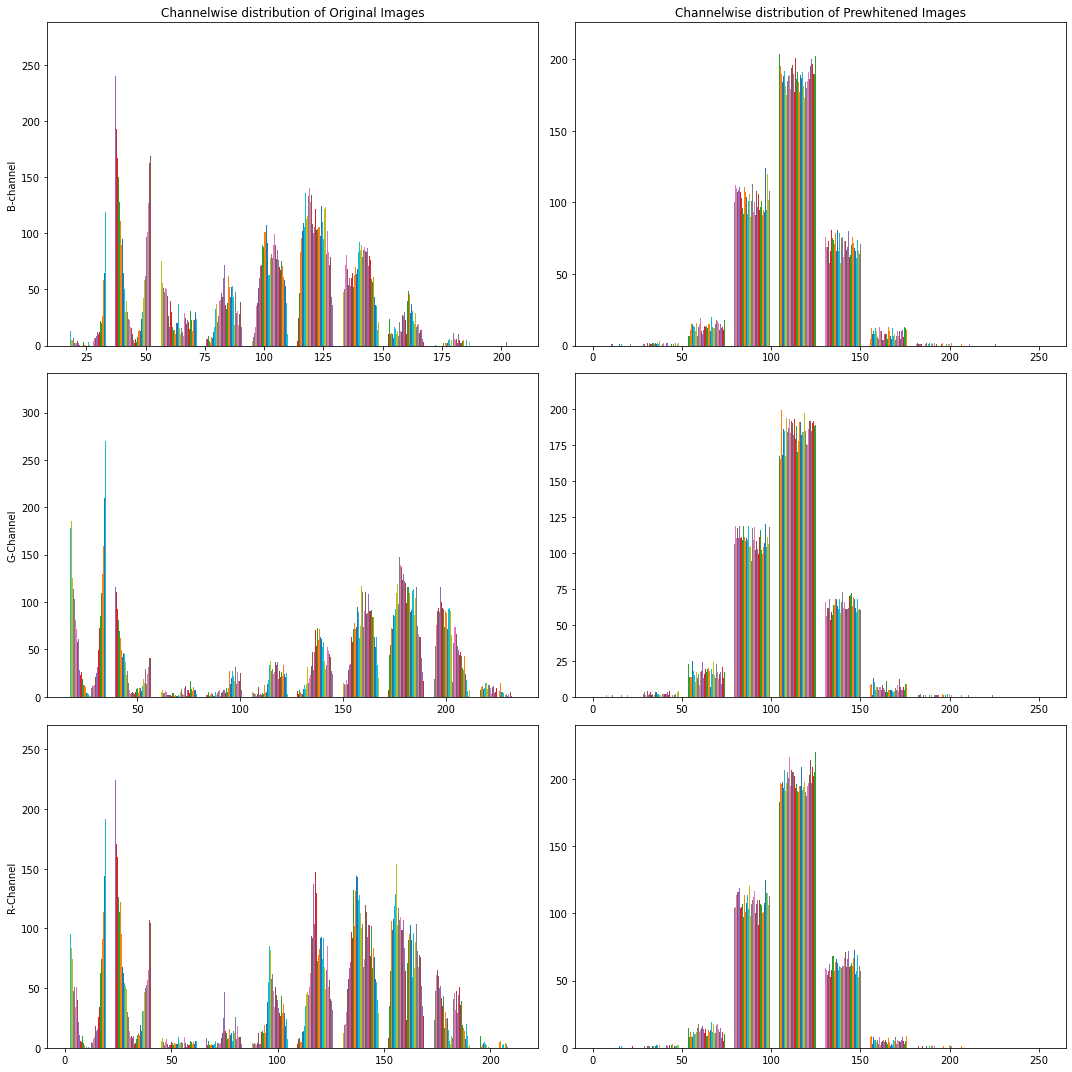

In [17]:
# To perform ZCA prewhitening for all images use following for loop
# for file in files:
#   ZCA_prewhitening(Images[file], show=False)

# For demonstration purpose we are showing only on one image
ZCA_prewhitening(Images[files[0]], show=True)

**TASK 2**

(898, 869, 3)


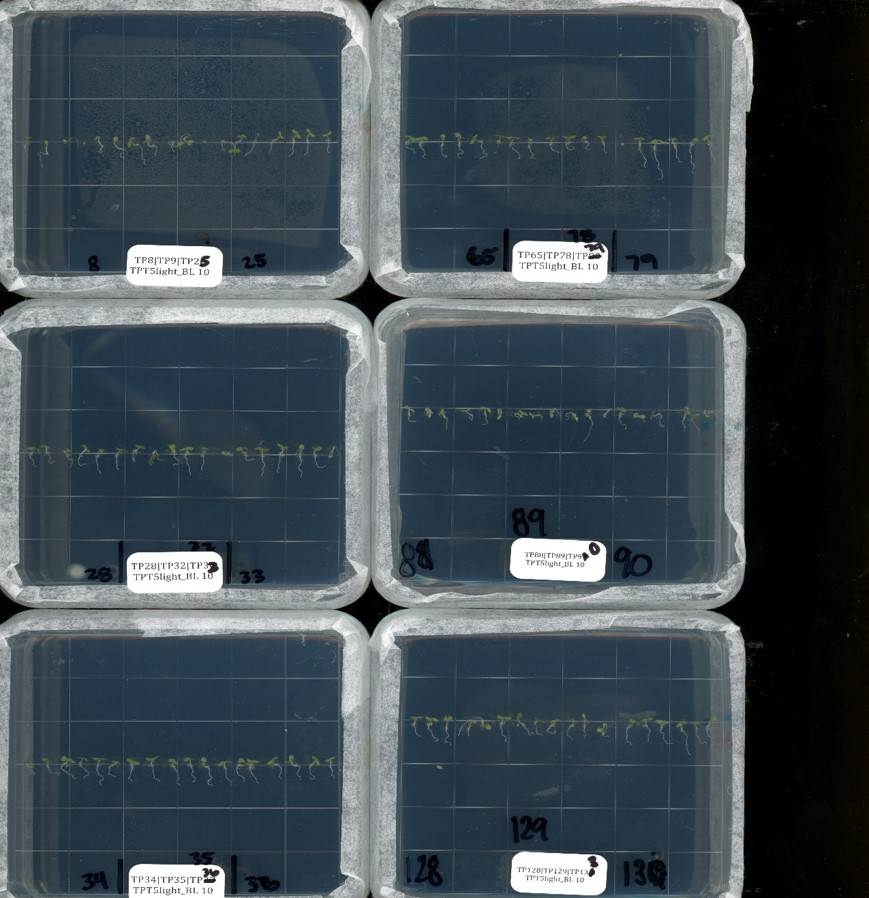

(892, 720, 3)


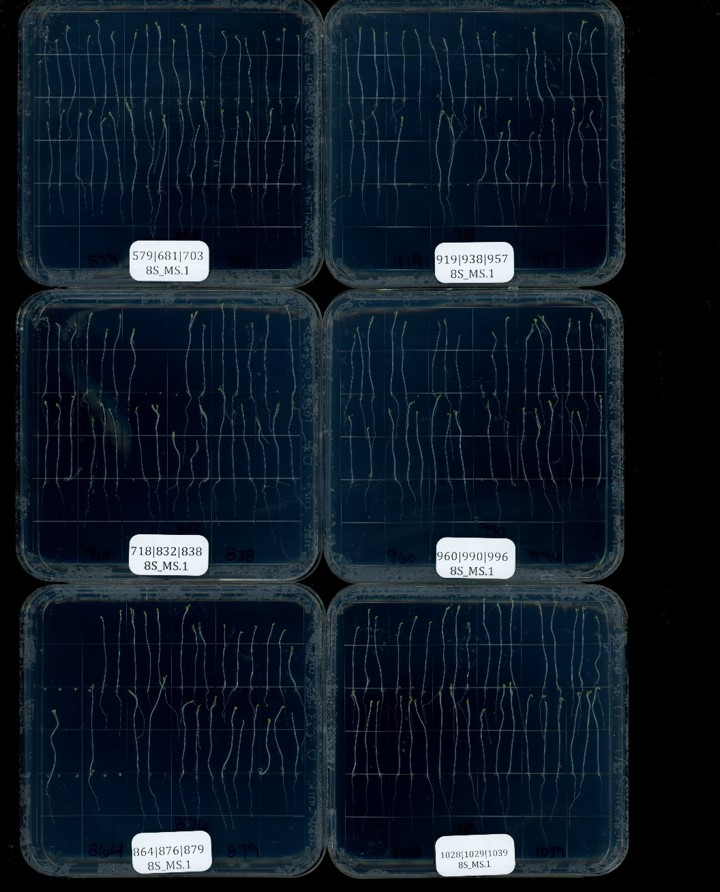

In [25]:
filepath2 = '/content/mnt/MyDrive/Colab Notebooks/ME592X/Assignment2/seedlings'
files2 = os.listdir(filepath2)
Images2 = {}
for file in files2:
  Images2[file] = cv2.imread('/content/mnt/MyDrive/Colab Notebooks/ME592X/Assignment2/seedlings/%s'%file, 0)
  
Images2_color = {}
for file in files2:
  Images2_color[file] = cv2.imread('/content/mnt/MyDrive/Colab Notebooks/ME592X/Assignment2/seedlings/%s'%file)
  print(Images2_color[file].shape)
  cv2_imshow(Images2_color[file])


In [9]:
gray = Images2[files2[1]]#[21:235, 42:294]

gray = cv2.bitwise_not(gray)
bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, \
                            cv2.THRESH_BINARY_INV, 15, -2)
print('########### Gray Scale Image ###########')
cv2_imshow(gray)
print('########### Thresholded binary Image using Adaptive thresholding ###########')
cv2_imshow(bw)

horizontal = np.copy(bw)
vertical = np.copy(bw)

# Specify size on horizontal axis
cols = horizontal.shape[1]
horizontal_size = cols // 30

# Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
# Apply morphology operations
horizontal = cv2.erode(horizontal, horizontalStructure)
horizontal = cv2.dilate(horizontal, horizontalStructure)

print('########### Detection of Horizontal elements ###########')
cv2_imshow(horizontal)

# Specify size on vertical axis
rows = vertical.shape[0]
verticalsize = rows // 30
# Create structure element for extracting vertical lines through morphology operations
verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))
# Apply morphology operations
vertical = cv2.erode(vertical, verticalStructure)
vertical = cv2.dilate(vertical, verticalStructure)

print('########### Detection of Vertical elements ###########')
cv2_imshow(vertical)

print('########### Removing the Horizontal grid lines from background from grayscale image ###########')
gray[horizontal == 255] = 255
cv2_imshow(gray)

ret,thresh1 = cv2.threshold(gray,220,255,cv2.THRESH_BINARY_INV)
print('########### Generating Binary mask to remove the grid lines from background ###########')
cv2_imshow(thresh1)


img_color = Images2_color[files2[1]]#[21:235, 42:294, :]
filtered_img = np.copy(img_color)
print('########### Original Color Image ###########')
cv2_imshow(img_color)


filtered_img[:, :, 0] = np.where(thresh1==255, img_color[:, :, 0], 0).astype('uint8')
filtered_img[:, :, 1] = np.where(thresh1==255, img_color[:, :, 1], 0).astype('uint8')
filtered_img[:, :, 2] = np.where(thresh1==255, img_color[:, :, 2], 0).astype('uint8')

print('########### Filtered Color Image ###########')
cv2_imshow(filtered_img)

Output hidden; open in https://colab.research.google.com to view.

########### Gray Scale Image ###########


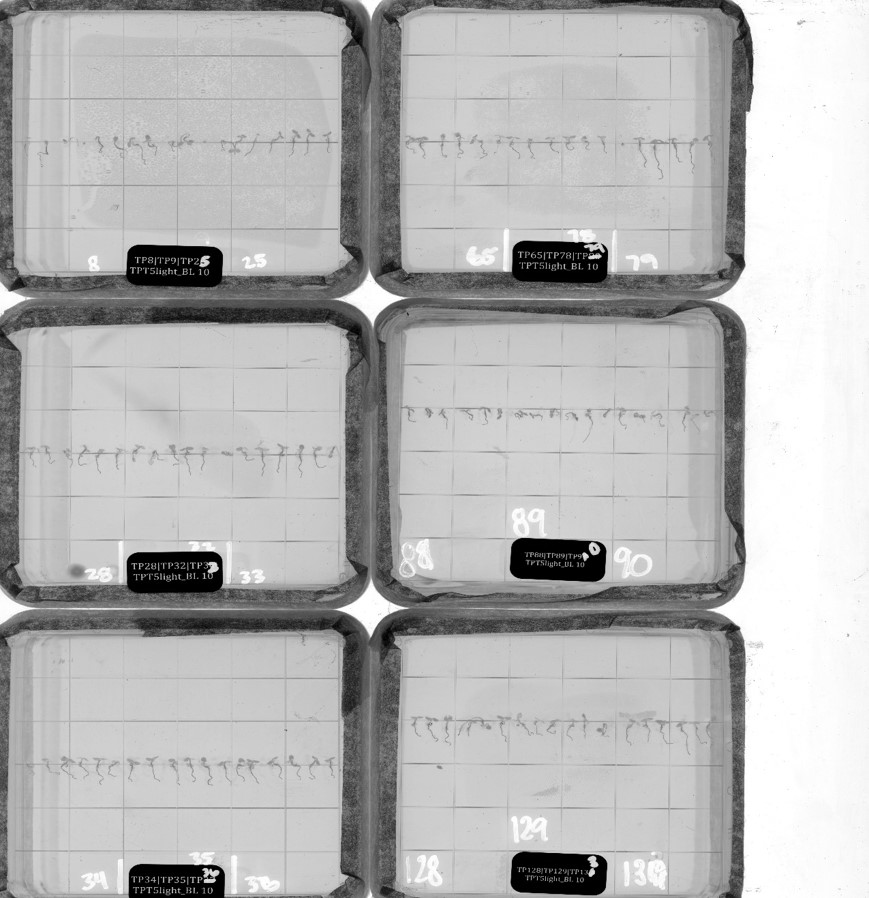

########### Thresholded binary Image using Adaptive thresholding ###########


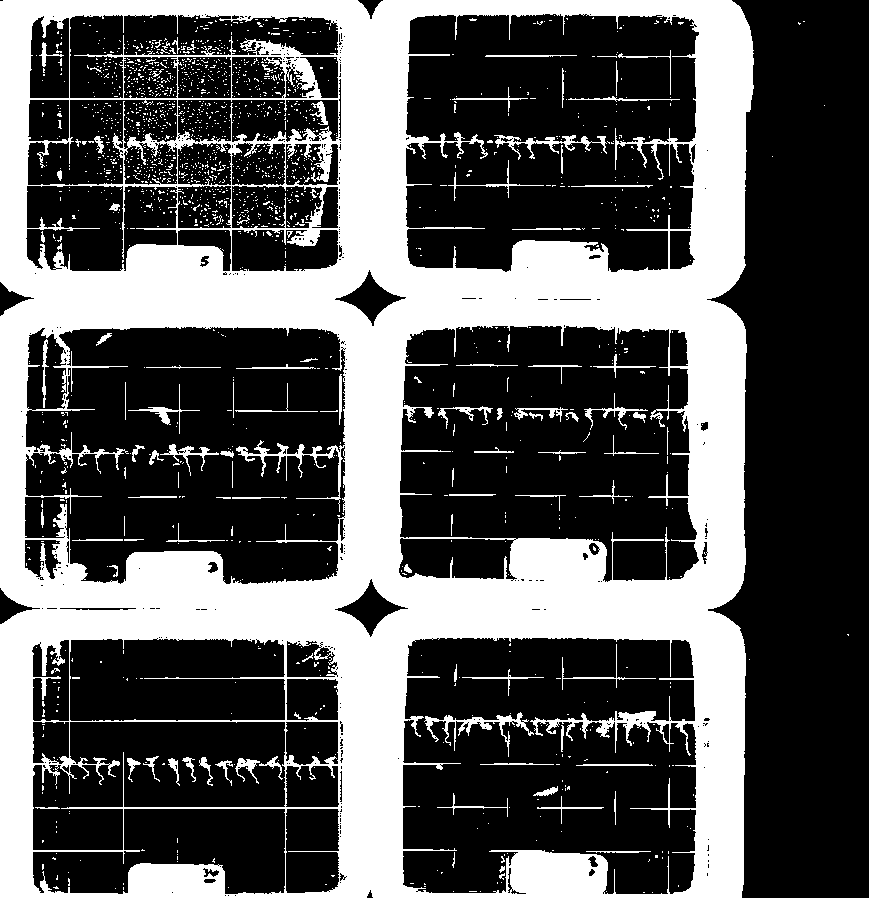

########### Detection of Horizontal elements ###########


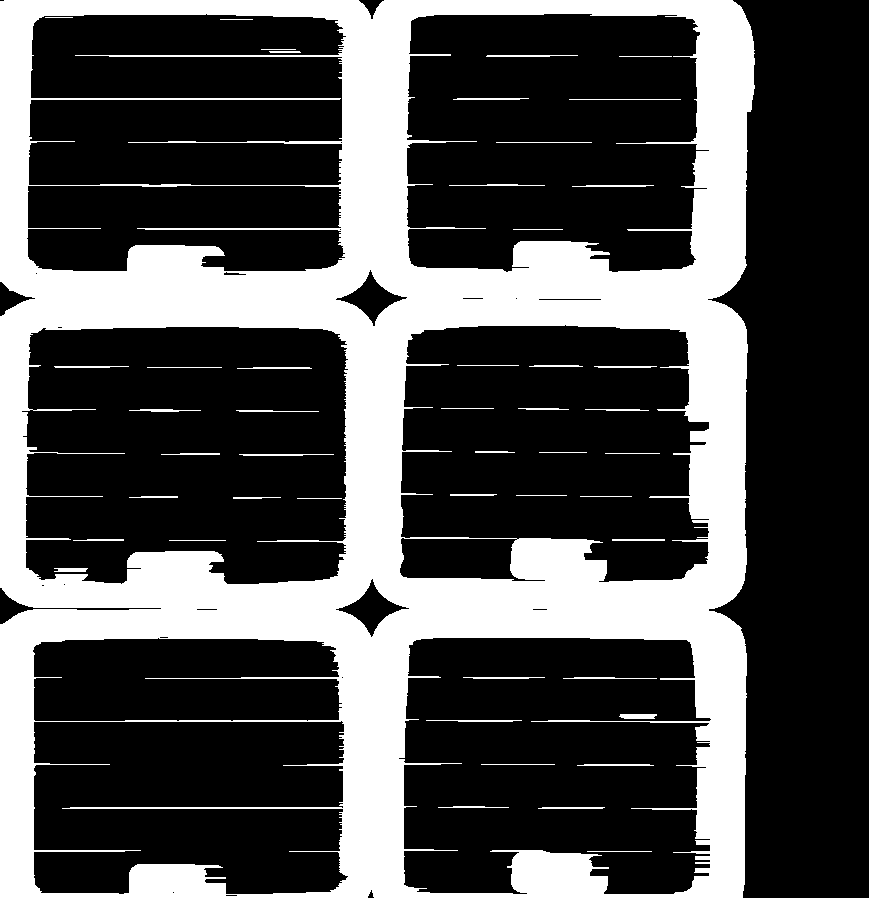

########### Detection of Vertical elements ###########


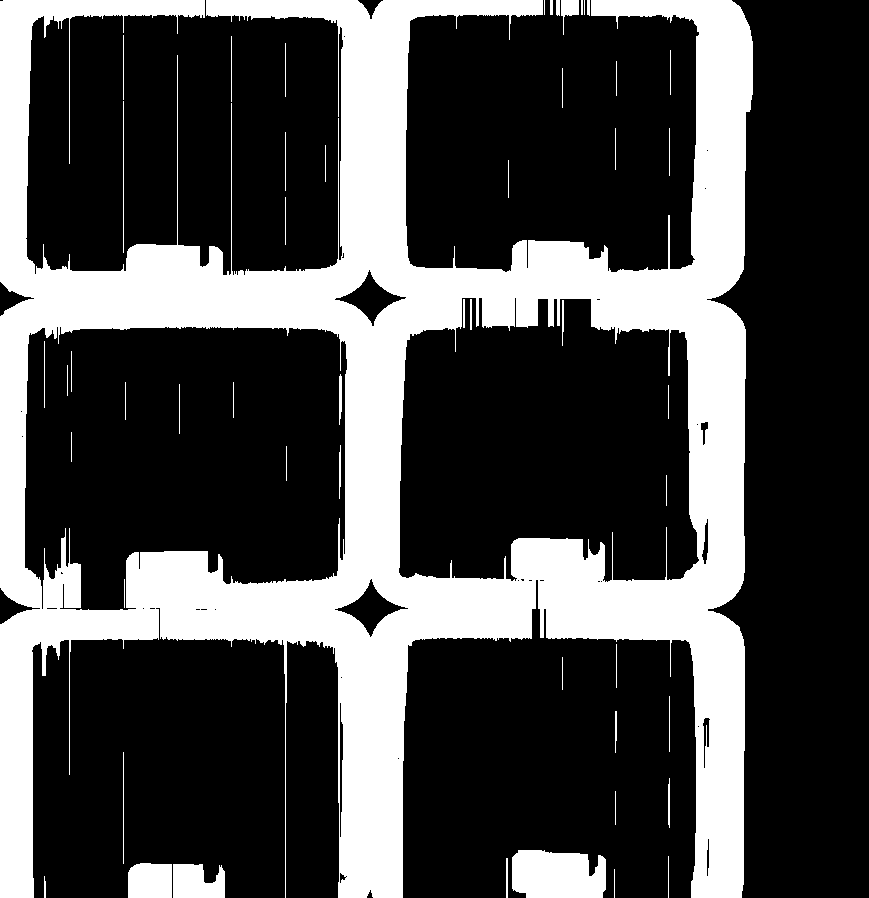

########### Removing the Horizontal and Vertical grid lines from background from grayscale image ###########


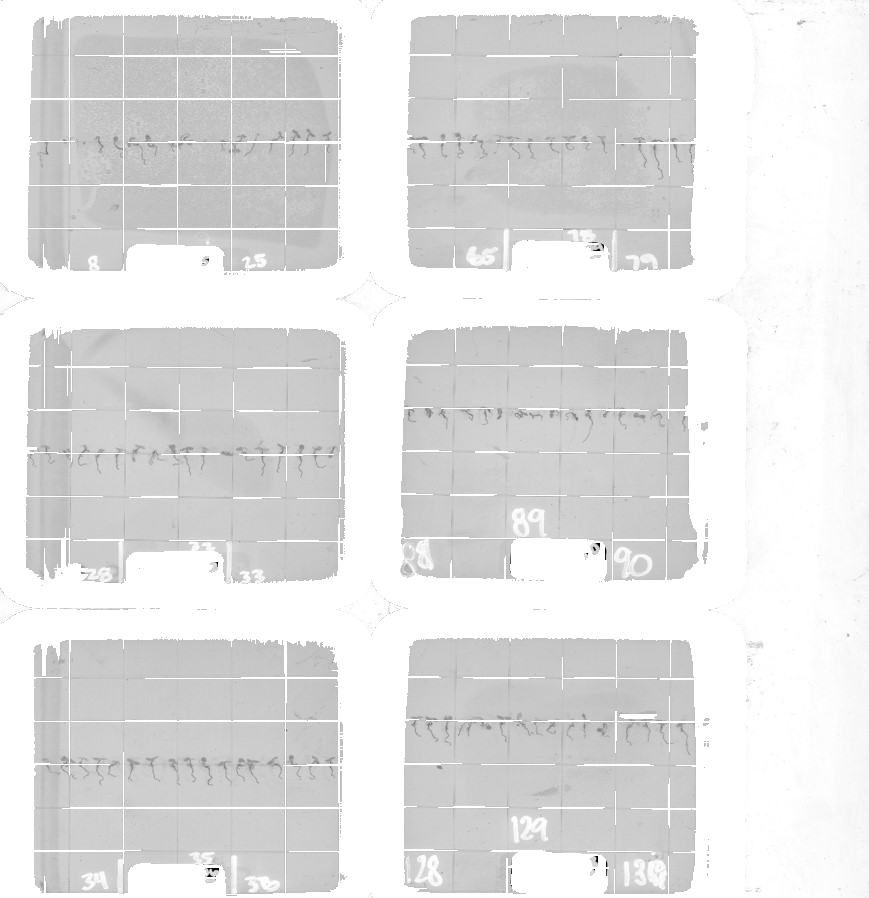

########### Generating Binary mask to remove the grid lines from background ###########


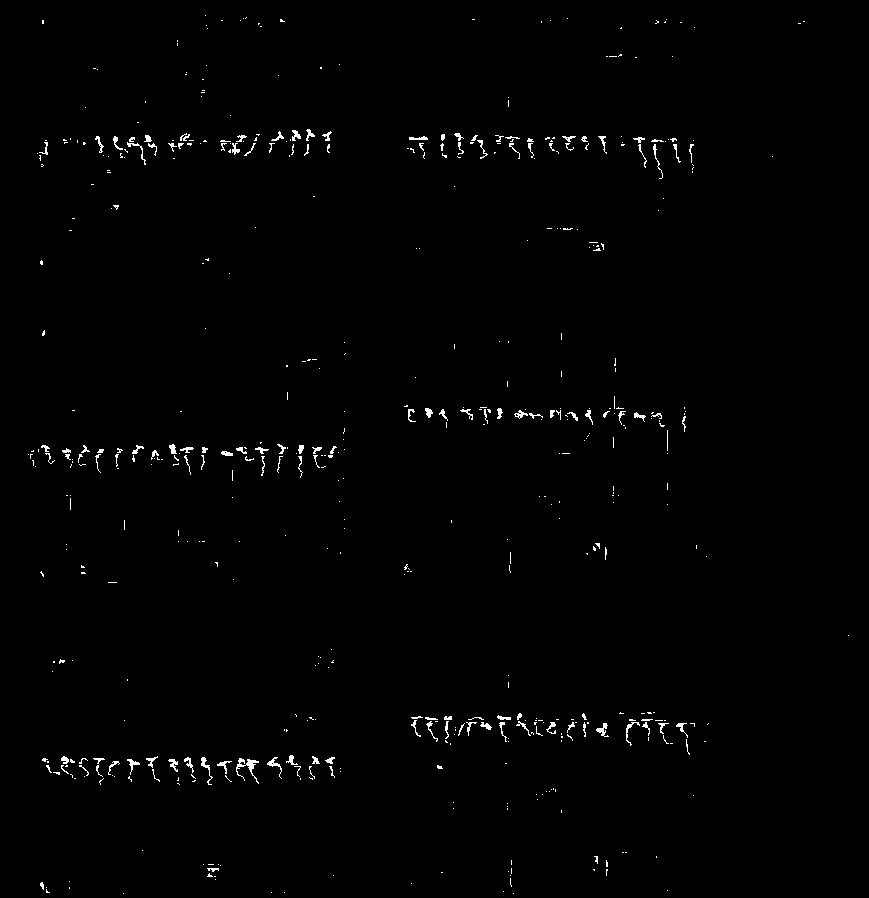

########### Original Color Image ###########


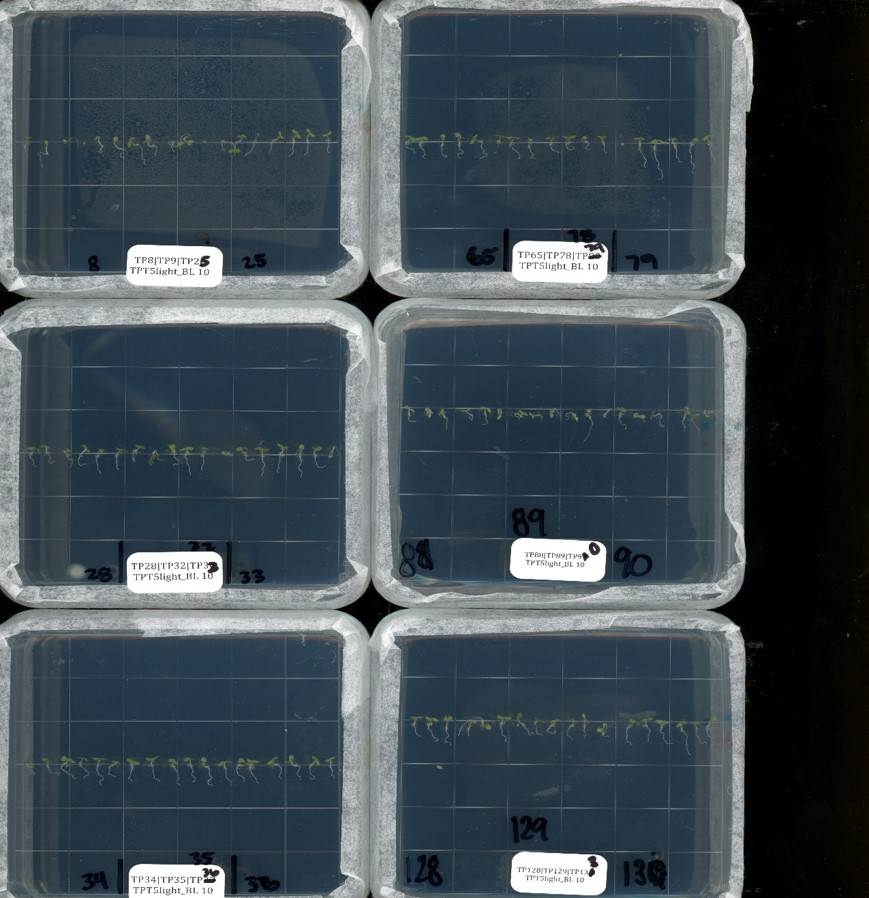

########### Filtered Color Image ###########


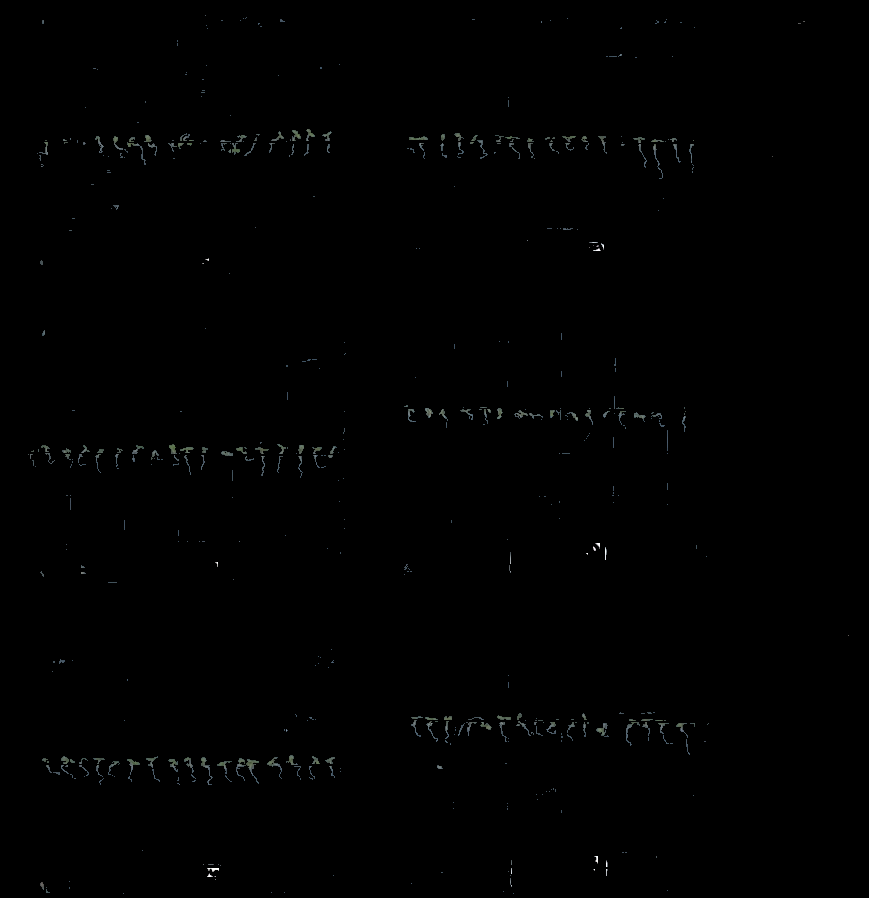

In [10]:
gray = Images2[files2[0]]#[21:235, 42:294]

gray = cv2.bitwise_not(gray)

ret,bw = cv2.threshold(gray,190,255,cv2.THRESH_BINARY_INV)
print('########### Gray Scale Image ###########')
cv2_imshow(gray)
print('########### Thresholded binary Image using Adaptive thresholding ###########')
cv2_imshow(bw)

horizontal = np.copy(bw)
vertical = np.copy(bw)

# Specify size on horizontal axis
cols = horizontal.shape[1]
horizontal_size = cols // 30

# Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
# Apply morphology operations
horizontal = cv2.erode(horizontal, horizontalStructure)
horizontal = cv2.dilate(horizontal, horizontalStructure)

print('########### Detection of Horizontal elements ###########')
cv2_imshow(horizontal)

# Specify size on vertical axis
rows = vertical.shape[0]
verticalsize = rows // 30
# Create structure element for extracting vertical lines through morphology operations
verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))
# Apply morphology operations
vertical = cv2.erode(vertical, verticalStructure)
vertical = cv2.dilate(vertical, verticalStructure)

print('########### Detection of Vertical elements ###########')
cv2_imshow(vertical)

print('########### Removing the Horizontal and Vertical grid lines from background from grayscale image ###########')
gray[horizontal == 255] = 255
gray[vertical == 255] = 255
cv2_imshow(gray)

ret,thresh1 = cv2.threshold(gray,180,255,cv2.THRESH_BINARY_INV)
print('########### Generating Binary mask to remove the grid lines from background ###########')
cv2_imshow(thresh1)


img_color = Images2_color[files2[0]]#[21:235, 42:294, :]
filtered_img = np.copy(img_color)
print('########### Original Color Image ###########')
cv2_imshow(img_color)


filtered_img[:, :, 0] = np.where(thresh1==255, img_color[:, :, 0], 0).astype('uint8')
filtered_img[:, :, 1] = np.where(thresh1==255, img_color[:, :, 1], 0).astype('uint8')
filtered_img[:, :, 2] = np.where(thresh1==255, img_color[:, :, 2], 0).astype('uint8')

print('########### Filtered Color Image ###########')
cv2_imshow(filtered_img)